## Importing necessary modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time
from tqdm import tqdm # Cool progress bar

import random
import numpy as np
import pandas as pd
import sys
import os # read and manipulate local files

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import cv2
import seaborn as sns

from PIL import Image

import tensorflow.keras as ks
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K # F1-score metric

from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import   Lambda, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, Flatten
from tensorflow.keras.layers import  GlobalAveragePooling2D, Reshape, Multiply, Attention, add,Resizing,  Input, Dense
from tensorflow.keras.layers import Activation,AveragePooling2D, MaxPooling2D, Dropout, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential

# hide wornings
import warnings
warnings.filterwarnings('ignore')

# from keras import ops# For deeplab3

# import keras_cv # basnet

# from imgaug import augmenters as iaa ## for augmentation

## Defining paths

In [ ]:
model_name = 'Inception_resnetV2_Unet_616'
################################################################################################
## SETTING THE PATHS
PATH_TO_CODE ='/content/drive/MyDrive/TRIAL_v1/segmentation_task'
# PATH_TO_CODE =''
sys.path.append(PATH_TO_CODE)

# DATASET_PATH = r'C:\Users\ASUS\Desktop\segmentation & cropping\segmentation_task\segmentation_data43_resized_cropped_split'
DATASET_PATH = r'/content/drive/MyDrive/TRIAL_v1/segmentation_task/segmentation_data43_resized_cropped_split'
# DATASET_PATH = r'segmentation_data43_resized_cropped_split'
DATASET_PATH_TRAIN = os.path.join(DATASET_PATH, 'train')
DATASET_PATH_TEST = os.path.join(DATASET_PATH, 'test')


PATH_TO_SAVE_RESULT = os.path.join(PATH_TO_CODE, 'saved_outputs_segmentation', model_name)
PATH_BEST_SAVE_WEIGHT = os.path.join(PATH_TO_SAVE_RESULT,'saved_weights')
PATH_TO_SAVE_MODEL = os.path.join(PATH_TO_SAVE_RESULT, 'saved_models')
PATH_SAVE_HISTORY = os.path.join(PATH_TO_SAVE_RESULT, model_name+'_training_history.csv')
PATH_SAVE_TIME = os.path.join(PATH_TO_SAVE_RESULT, model_name+'_training_time.csv')
PATH_SAVE_AUGMENT_SAMPLE = os.path.join(PATH_TO_SAVE_RESULT, model_name+'_augmented_sample.pdf')
PATH_SAVE_PIXEL_PERCENTAGE_PLOT = os.path.join(PATH_TO_SAVE_RESULT, model_name+'_pixel_percentage.pdf')
# PATH_TO_SAVE_TUNER = os.path.join(PATH_TO_RESULT, 'saved_tuner_model')
################################################################################################

if not os.path.exists(PATH_TO_SAVE_RESULT):
 # If it does not exist, create it
    os.makedirs(PATH_TO_SAVE_RESULT)
################################################################################################
IMG_HEIGHT = 256
IMG_WIDTH = 256
ORIGINAL_IMAGE_SIZE = (IMG_HEIGHT, IMG_WIDTH)
COLOR_CHANNEL = 3

RESIZE_SHAPE = ORIGINAL_IMAGE_SIZE #(128, 128) #ORIGINAL_IMAGE_SIZE#(128, 128)# # #ORIGINAL_IMAGE_SIZE# (128, 128)#
MODEL_INPUT_SIZE = (RESIZE_SHAPE[0], RESIZE_SHAPE[1], COLOR_CHANNEL)

VALIDATION_SPLIT= 0.2
NUM_CLASSES = 2 # Disease and not disease

BATCH_SIZE = 10
EPOCHS = 70

INITIAL_LR = 0.001

TOTAL_DATA = 616
################################################################################################

################################################################################################

SAVE_RESULTS = True
SHOW_RESULTS = True

################################################################################################
# Setting the seed
SEED  = 123
RNG = np.random.default_rng(SEED) # Random number generator
tf.random.set_seed(SEED)

################################################################################################
# Checkpoint parameters val_binary_io_u
SCORE_TO_MONITOR = 'val_binary_io_u' # Score that checkpoints monitor during training
SCORE_OBJECTIVE  = 'max'          # 'max' or 'min', specifies whether the objective is to maximize the score or minimize it.
PATIENCE_LR_REDUCE = 5
MIN_LR = 1e-8
REDUCTION_FACTOR = 0.5            # Factor which lr will be reduced with at plateau
COOLDOWN_EPOCHS  = 2 #cooldown: Integer. Number of epochs to wait before resuming normal operation after the learning rate has been reduced.

INITIAL_LR = 0.001

## Defining performance metrics

Official segmentation metrics by keras: https://ks.io/api/metrics/segmentation_metrics/

In [ ]:
def f1_score(y_true, y_pred): # Dice coefficient
    """
    Calculate the F1 score, the harmonic mean of precision and recall, for binary classification.

    Args:
        y_true (Tensor): True binary labels.
        y_pred (Tensor): Predicted probabilities.

    Returns:
        float32: F1 score as a scalar.
    """
    # True Positives: round product of y_true and y_pred
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    # Actual Positives: round y_true
    P = K.sum(K.round(K.clip(y_true, 0, 1)))
    # Recall: TP / Actual Positives
    recall = TP / (P + K.epsilon())

    # Predicted Positives: round y_pred
    Pred_P = K.sum(K.round(K.clip(y_pred, 0, 1)))
    # Precision: TP / Predicted Positives
    precision = TP / (Pred_P + K.epsilon())

    # F1 Score: harmonic mean of precision and recall
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# source: https://www.tensorflow.org/api_docs/python/tf/keras/metrics/BinaryIoU
iou_score_binary = tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)

def accuracy_score(y_true, y_pred):
    """
    Calculate accuracy score between two binary masks.
    """
    correct = np.sum(y_true == y_pred)  # Count correct predictions
    total = y_true.size  # Total number of pixels
    return correct / total  # Accuracy calculation

def precision_score(groundtruth_mask, pred_mask):
    """
    Calculate precision score between two binary masks.
    """
    intersect = np.sum(pred_mask * groundtruth_mask)  # Calculate intersection
    total_pixel_pred = np.sum(pred_mask)  # Sum of predicted positives
    return np.mean(intersect / total_pixel_pred)  # Precision calculation

def recall_score(groundtruth_mask, pred_mask):
    """
    Calculate recall score between two binary masks.
    """
    intersect = np.sum(pred_mask * groundtruth_mask)  # Calculate intersection
    total_pixel_truth = np.sum(groundtruth_mask)  # Sum of actual positives
    return np.mean(intersect / total_pixel_truth)  # Recall calculation

## Reading the data

In [ ]:
# Function to read images from a directory using Pillow
def read_images_from_directory(directory_path):
    images = []
    for filename in sorted(os.listdir(directory_path)):
        # filename= filename.lower()

        if filename.endswith(('.png', '.jpg', '.JPG' )):  # Check for image file extensions
            img_path = os.path.join(directory_path, filename)
            img = Image.open(img_path)
            img_array = np.array(img)  # Convert the image to a numpy array if needed
            if img_array is not None:
                images.append(img_array)
    return images

# Paths to masks and original images within the dataset
masks_path_train = os.path.join(DATASET_PATH_TRAIN, 'data43_masks_binarised')
originals_path_train = os.path.join(DATASET_PATH_TRAIN, 'data43_original')

# Read images into variables
x_train = read_images_from_directory(originals_path_train)  # Original images
y_train = read_images_from_directory(masks_path_train)  # Masks

# Paths to masks and original images within the test dataset
masks_path_test = os.path.join(DATASET_PATH_TEST, 'data43_masks_binarised')
originals_path_test = os.path.join(DATASET_PATH_TEST, 'data43_original')

# Read images into variables
x_test = read_images_from_directory(originals_path_test)  # Original images
y_test = read_images_from_directory(masks_path_test)  # Masks

# Now x_train contains original images, and y_train contains mask images
print(f"Loaded {len(x_train)} original images into x_train")
print(f"Loaded {len(y_train)} mask images into y_train")

# Similarly, for test images
print(f"Loaded {len(x_test)} original images into x_test")
print(f"Loaded {len(y_test)} mask images into y_test")

Loaded 616 original images into x_train
Loaded 616 mask images into y_train
Loaded 23 original images into x_test
Loaded 23 mask images into y_test


## Checking if the masks are correct

In [ ]:
def has_other_values(images):
    """
    Check if the numpy array 'images' contains any pixel values other than 0 and 255.

    Parameters:
    images (list of numpy.ndarray): A list of numpy arrays, each containing image data.

    Returns:
    str: A message indicating whether other pixel values are present.
    """
    # Iterate through each image in the list
    for image in images:
        # Check if any value in the image is not equal to 0 or 255
        if np.any((image != 0) & (image != 255)):
            return "Has other pixel values"
    return "Only contains 0 and 255"


# Check y_train for any values other than 0 and 255
result_train = has_other_values(y_train)
print("y_train:", result_train)

# Check y_test for any values other than 0 and 255
result_test = has_other_values(y_test)
print("y_test:", result_test)

y_train: Only contains 0 and 255
y_test: Only contains 0 and 255


## Visualization

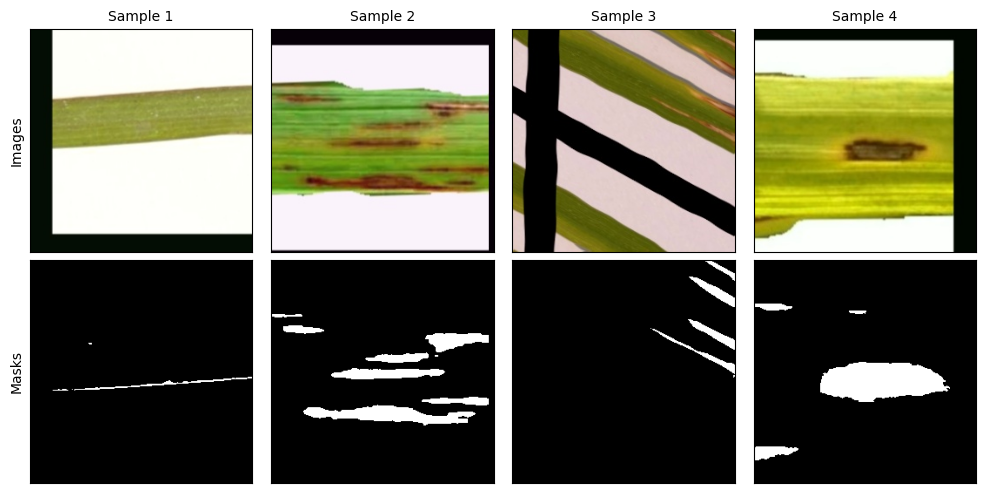

In [ ]:
indices = np.array([i for i in range(len(x_train))])
plot_indices = RNG.choice(indices, size=4, replace=False)

fig, ax = plt.subplots(2,4, figsize=(10,5))
for i in range(len(plot_indices)):
    X_plot = x_train[plot_indices[i]]
    y_plot = y_train[plot_indices[i]]
    ax[0,i].imshow(X_plot)
    ax[1,i].imshow(y_plot, cmap = 'gray')

ax[0,0].set_title('Sample 1', fontsize=10)
ax[0,1].set_title('Sample 2', fontsize=10)
ax[0,2].set_title('Sample 3', fontsize=10)
ax[0,3].set_title('Sample 4', fontsize=10)

ax[0,0].set_ylabel('Images')
ax[1,0].set_ylabel('Masks')

for axes in ax.flatten():
    axes.set_xticks([])
    axes.set_yticks([])

fig.tight_layout()
# plt.show()

if SAVE_RESULTS:
    # Save the plot to a PDF
    with PdfPages(PATH_SAVE_AUGMENT_SAMPLE) as pdf:
        pdf.savefig(fig)
        if SHOW_RESULTS:
            plt.show()
        else:
            plt.close()

100%|██████████| 616/616 [00:00<00:00, 13648.73it/s]


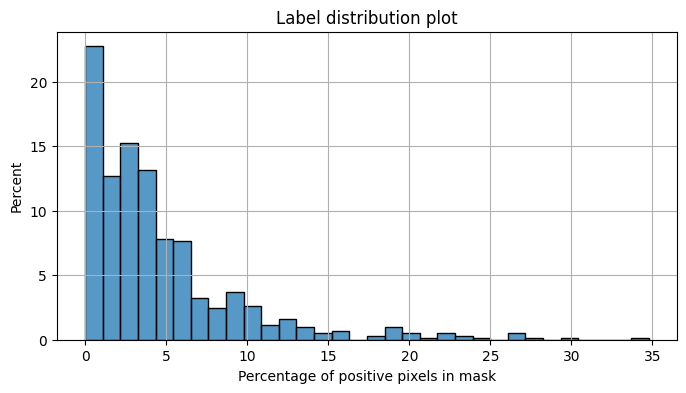

In [ ]:
positive_pixel_count = np.zeros(len(y_train))
#image_size = x_train.shape[1]*x_train.shape[2]
image_size = ORIGINAL_IMAGE_SIZE[0] * ORIGINAL_IMAGE_SIZE[1]#x_train.shape[1]*x_train.shape[2]
for i in tqdm(range(len(y_train))):
    single_y = y_train[i]
    positive_pixel_count[i] = np.sum(single_y != 0) / image_size * 100

fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.histplot(positive_pixel_count, stat='percent', ax=ax)
ax.set_xlabel('Percentage of positive pixels in mask')
ax.set_title('Label distribution plot')
ax.grid('on')
plt.show()

if SAVE_RESULTS:
    # Save the plot to a PDF
    with PdfPages(PATH_SAVE_PIXEL_PERCENTAGE_PLOT) as pdf:
        pdf.savefig(fig)
        if SHOW_RESULTS:
            plt.show()
        else:
            plt.close()

## Preprocessing DO NOT RESIZE THE IMAGE-- IT GIVES FINE LINES IN THE OUTPUT

In [ ]:
# # # Resizing
# x_train = [np.array(Image.fromarray(image).resize(RESIZE_SHAPE)) for image in x_train]
# y_train = [np.array(Image.fromarray(image).resize(RESIZE_SHAPE)) for image in y_train]

# x_test = [np.array(Image.fromarray(image).resize(RESIZE_SHAPE)) for image in x_test]
# y_test = [np.array(Image.fromarray(image).resize(RESIZE_SHAPE)) for image in y_test]

# Convert the list to a NumPy array
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)


# Normalizing input between [0,1]
x_train = x_train.astype("float32")/ np.max(x_train)
x_test  = x_test.astype("float32")/np.max(x_test)

y_train = y_train.astype("float32")/ np.max(y_train)
y_test  = y_test.astype("float32")/np.max(y_test)

# Now x_train contains original images, and y_train contains mask images
print(f"Loaded {len(x_train)} original images into x_train")
print(f"Loaded {len(y_train)} mask images into y_train")

# Similarly, for test images
print(f"Loaded {len(x_test)} original images into x_test")
print(f"Loaded {len(y_test)} mask images into y_test")

Loaded 616 original images into x_train
Loaded 616 mask images into y_train
Loaded 23 original images into x_test
Loaded 23 mask images into y_test


## Checking if the masks are correct

In [ ]:
def has_other_values(images):
    """
    Check if the numpy array 'images' contains any pixel values other than 0 and 1.

    Parameters:
    images (list of numpy.ndarray): A list of numpy arrays, each containing image data.

    Returns:
    str: A message indicating whether other pixel values are present.
    """
    # Iterate through each image in the list
    for image in images:
        # Check if any value in the image is not equal to 0 or 1
        if np.any((image != 0) & (image != 1)):
            return "Has other pixel values"
    return "Only contains 0 and 1"


# Check y_train for any values other than 0 and 1
result_train = has_other_values(y_train)
print("y_train:", result_train)

# Check y_test for any values other than 0 and 1
result_test = has_other_values(y_test)
print("y_test:", result_test)

y_train: Only contains 0 and 1
y_test: Only contains 0 and 1


## Visualization after pre-processing for checking condition

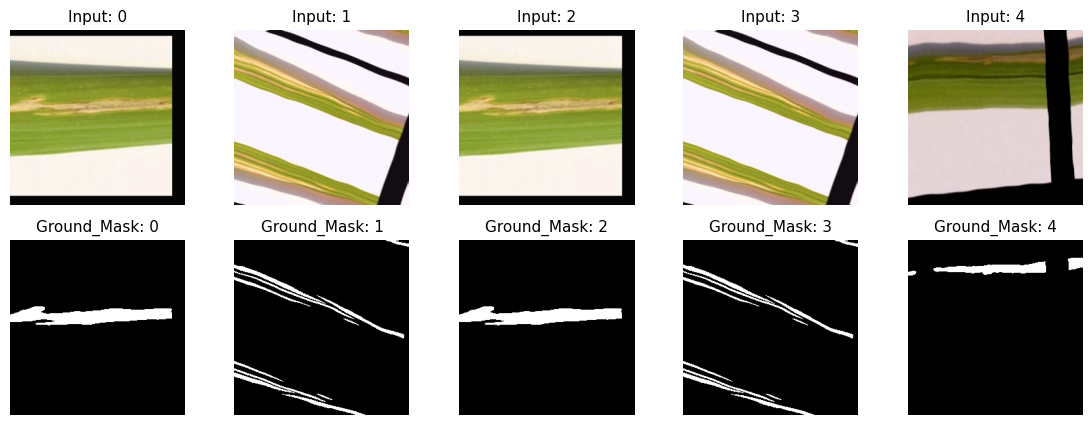

In [ ]:
Rand_Nub = RNG.integers(1,10,5)
fig, ax = plt.subplots(2, 5 ,figsize=(14,5))#width, h
for i in range(Rand_Nub.shape[0]):
    ax[0, i].imshow(x_train[Rand_Nub[i]])
    ax[0, i].axes.xaxis.set_ticklabels([])
    ax[0, i].axes.yaxis.set_ticklabels([])
    ax[0, i].set_title('Input: '+str(i), fontsize=11)
    ax[0, i].axis('off')

    ax[1, i].imshow(y_train[Rand_Nub[i]] ,cmap = 'gray')
    ax[1, i].axes.xaxis.set_ticklabels([])
    ax[1, i].axes.yaxis.set_ticklabels([])
    ax[1, i].set_title('Ground_Mask: '+str(i), fontsize=11)
    ax[1, i].axis('off')

## Essential functions

In [ ]:
def fit_and_save_best_model(model_name, model, epochs=EPOCHS):
    ##########################################################################################################
    saved_best_model_name = 'best_'+model_name+'.h5'

    model_saving_path = os.path.join(PATH_TO_SAVE_MODEL, saved_best_model_name)
    # Set up a model checkpoint to save the best model during training
    best_model_callback= ModelCheckpoint(model_saving_path,
                                          monitor=SCORE_TO_MONITOR,
                                          save_best_only=True,
                                          mode=SCORE_OBJECTIVE,
                                          verbose=1)

    reduce_LR = ReduceLROnPlateau(
        factor=REDUCTION_FACTOR,      # Factor by which the learning rate will be reduced. new_lr = lr * factor
        patience=PATIENCE_LR_REDUCE, # original was 5      # Number of epochs with no improvement after which learning rate will be reduced.
        verbose=1,       # int. 0: quiet, 1: update messages.
        min_lr=MIN_LR   # Lower bound on the learning rate.
    )

    my_callbacks = [best_model_callback , reduce_LR]
    ##########################################################################################################

    start_time = time.time()

    # Fitting the model
    train_history = model.fit(
        x_train,
        y_train,
        epochs= epochs,
        batch_size=BATCH_SIZE,
        validation_split= VALIDATION_SPLIT,
        callbacks=my_callbacks,
    )
    total_time = time.time() - start_time

    return saved_best_model_name, train_history, total_time

In [ ]:
def plot_training_history(training_history_object, list_of_metrics=None):
    """
    Input:
        training_history_object:: Object returned by model.fit() function in keras
        list_of_metrics        :: A list of metrics to be plotted. Use if you only
                                  want to plot a subset of the total set of metrics
                                  in the training history object. By Default it will
                                  plot all of them in individual subplots.
    """
    history_dict = training_history_object.history

    ###################addDED NEW################################################
    ###Remove 'lr' and 'val_lr' keys from history_dict if they exist
    history_dict.pop('lr', None)
    history_dict.pop('val_lr', None)
    #############################################################################

    if list_of_metrics is None:
        list_of_metrics = [key for key in list(history_dict.keys()) if 'val_' not in key]

    # print(list_of_metrics)
    trainHistDF = pd.DataFrame(history_dict)
    # trainHistDF.head()
    train_keys = list_of_metrics
    valid_keys = ['val_' + key for key in train_keys]
    nr_plots = len(train_keys)
    fig, ax = plt.subplots(1,nr_plots,figsize=(4*nr_plots,4))
    for i in range(len(train_keys)):
        ax[i].plot(np.array(trainHistDF[train_keys[i]]), label='Training')
        ax[i].plot(np.array(trainHistDF[valid_keys[i]]), label='Validation')
        ax[i].set_xlabel('Epoch')
        if train_keys[i] == 'binary_io_u':
             ax[i].set_title('IoU')
        else:
            ax[i].set_title(train_keys[i])
        ax[i].grid('on')
        ax[i].legend()
    fig.tight_layout()


    if SAVE_RESULTS:
        # Save the plot to a PDF
        pdf_filename = os.path.join(PATH_TO_SAVE_RESULT, f"{model_name}_training_history.pdf")
        with PdfPages(pdf_filename) as pdf:
            pdf.savefig(fig)
            if SHOW_RESULTS:
                plt.show()
            else:
                plt.close()

## Models
### Models worked
- Model01: Basic basic_unet
- Model02: unet_vgg16 (my own custom)
- Model03: TransUNet
- Model04: DeepLab-v3Plus
- Model05: ResUNet
- Model06: UNet_with_attention
- Model07: Multi-resUnet
- Model08: Inception_resnetV2 (my own custom)



### InceptionResNetV2---Works--checked with batch size10

In [ ]:
from tensorflow.keras.applications import  InceptionResNetV2
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def get_unet_InceptionResNetV2(n_filters=16, batchnorm=True, dropout=0.1):
    InceptionResNetV2_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=MODEL_INPUT_SIZE)

    # Encoder
    encoder = InceptionResNetV2_base.get_layer('activation_89').output

    # Bottleneck
    bottleneck = Conv2D(512, (3, 3), activation='relu', padding='same')(encoder)

    # Resizing for skip connections
    resized_skip1 = tf.image.resize(InceptionResNetV2_base.get_layer('activation_89').output, [28, 28])
    resized_skip2 = tf.image.resize(InceptionResNetV2_base.get_layer('max_pooling2d').output, [56, 56])
    resized_skip3 = tf.image.resize(InceptionResNetV2_base.get_layer('conv2d_1').output, [112, 112])

    # Decoder
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding='same')(bottleneck)
    u6 = Concatenate(axis=-1)([u6, resized_skip1])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate(axis=-1)([u7, resized_skip2])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)

    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size=3, batchnorm=batchnorm)

    # Final upsampling to match the original input size
    u9 = Conv2DTranspose(n_filters, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters, kernel_size=3, batchnorm=batchnorm)

    # Additional resizing layer to ensure output is 256x256
    final_output = Resizing(256, 256, interpolation='bilinear')(c9)

    outputs = Conv2D(NUM_CLASSES-1, (1, 1), activation='sigmoid')(final_output)
    model = Model(inputs=InceptionResNetV2_base.input, outputs=[outputs])
    optimizer = Adam(learning_rate=INITIAL_LR)
    model.compile(loss='binary_crossentropy',
                  metrics=['accuracy', f1_score, iou_score_binary],
                  optimizer=optimizer)

    return model


## Train and Results

In [ ]:
# model= get_basic_unet() ## Model1
# model= get_unet_vgg16() ## Model2
# model= get_TransUNet() ## Model3
# model= get_DeepLabV3Plus() ## Model4
# model = get_ResUNet_v3() ## Model5
# model = UNet_with_attention() ## Model6
# model = get_multiresunet() ## Model7
model = get_unet_InceptionResNetV2() ## Model8

model.summary()

219055592/219055592 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)   

In [ ]:
# training the model and saving the best model as a check point
best_model_name, train_history, total_time = fit_and_save_best_model(model_name, model)

Epoch 1/70
50/50 [==============================] - ETA: 0s - loss: 0.3274 - accuracy: 0.9440 - f1_score: 0.5686 - binary_io_u: 0.6480
Epoch 1: val_binary_io_u improved from -inf to 0.23605, saving model to /content/drive/MyDrive/TRIAL_v1/segmentation_task/saved_outputs_segmentation/Inception_resnetV2_Unet_616/saved_models/best_Inception_resnetV2_Unet_616.h5
50/50 [==============================] - 56s 216ms/step - loss: 0.3274 - accuracy: 0.9440 - f1_score: 0.5686 - binary_io_u: 0.6480 - val_loss: 2.1219 - val_accuracy: 0.4296 - val_f1_score: 0.1329 - val_binary_io_u: 0.2361 - lr: 0.0010
Epoch 2/70
50/50 [==============================] - ETA: 0s - loss: 0.1736 - accuracy: 0.9763 - f1_score: 0.6950 - binary_io_u: 0.7657
Epoch 2: val_binary_io_u improved from 0.23605 to 0.62757, saving model to /content/drive/MyDrive/TRIAL_v1/segmentation_task/saved_outputs_segmentation/Inception_resnetV2_Unet_616/saved_models/best_Inception_resnetV2_Unet_616.h5
50/50 [==============================] -

In [ ]:
# Saving the time to be reused
time_data = {
    "model_name": [model_name],
    "run_time": [total_time]
}

# Convert the dictionary to a pandas DataFrame
time_df = pd.DataFrame(time_data)

# Save the DataFrame to a CSV file
time_df.to_csv(PATH_SAVE_TIME, index=False)

In [ ]:
# Saving the history as csv file to be reused
history_df = pd.DataFrame(train_history.history)
history_df.to_csv(PATH_SAVE_HISTORY, index=False)

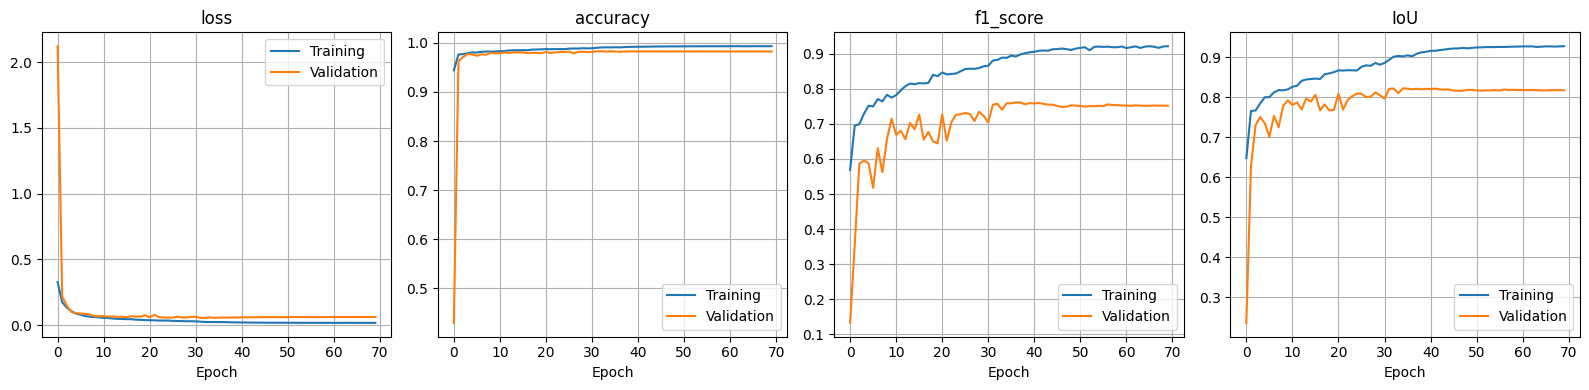

In [ ]:
# plotting train history
plot_training_history(train_history)

## Loading the best model

In [ ]:
##Now, load the best model
best_model = ks.models.load_model(os.path.join(PATH_TO_SAVE_MODEL, best_model_name),
                                  custom_objects={'f1_score': f1_score,
                                                  'binary_io_u':iou_score_binary})

# best_model =model

## Visualize model predictions

In [ ]:
# Get predictions from the model
predictions = best_model.predict(x_test, verbose=1)

USER_DETERMINED_THRESHOLD = 0.5
thresholded_predictions  = (predictions  >= USER_DETERMINED_THRESHOLD)
# Removing the color channel
thresholded_predictions_without_color_channel = np.squeeze(thresholded_predictions, axis=-1)

1/1 [==============================] - 3s 3s/step


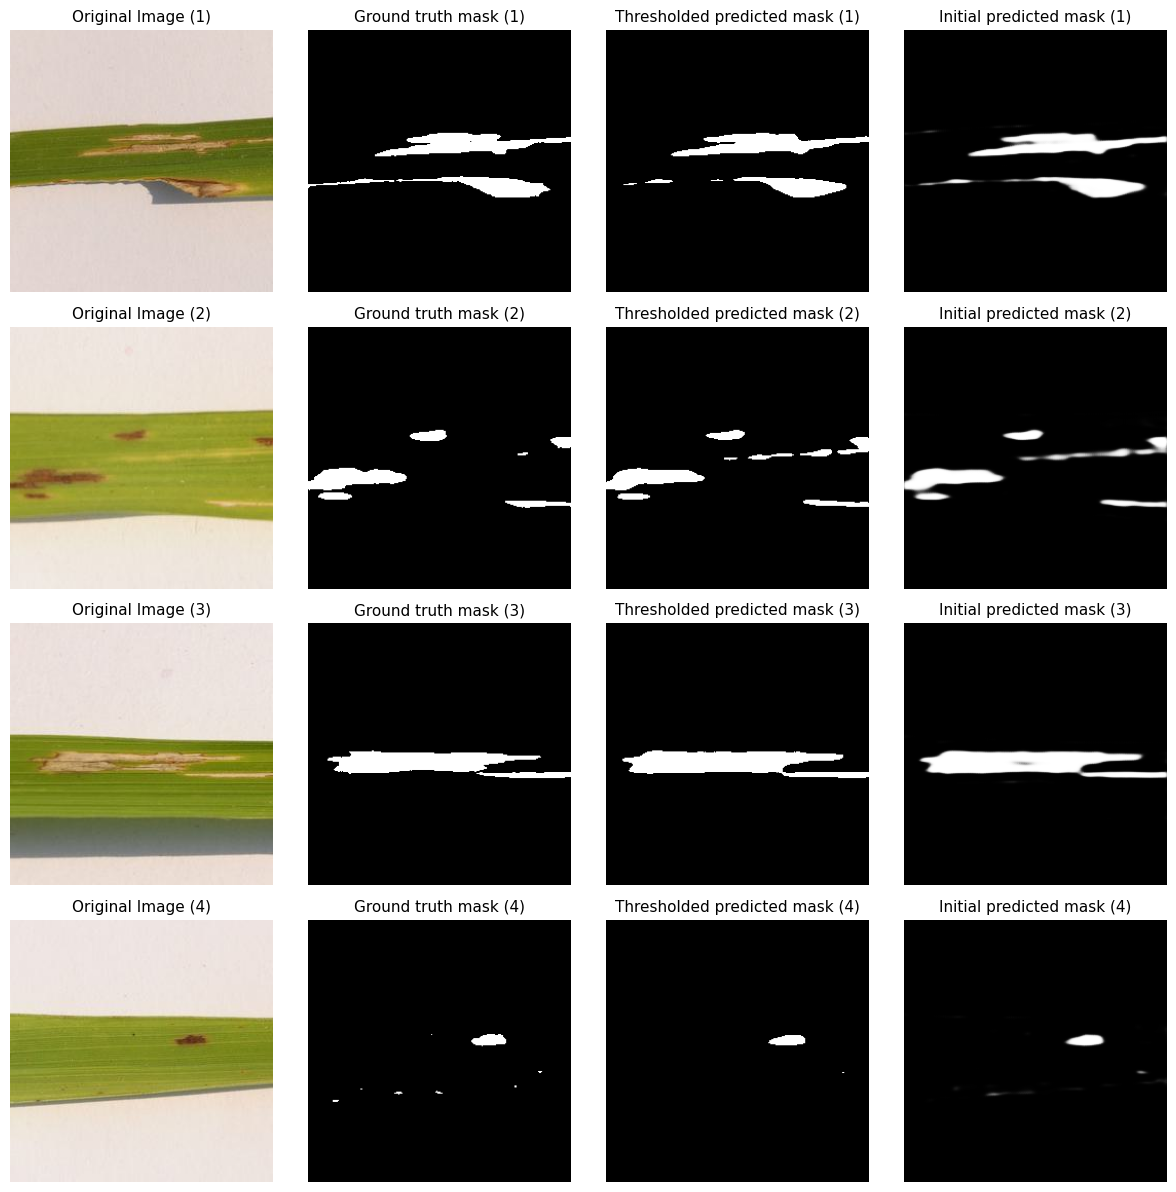

In [ ]:
############################################################################################################]

# Define the number of images to visualize
num_images = 4

# Create a figure with subplots
fig, axes = plt.subplots(num_images, 4, figsize=(12, 3 * num_images))

sample_indices = [0, 13, 4, 18]  #
# for i in range(num_images):
for i, chosen_index in enumerate(sample_indices):
    # Display original image
    axes[i, 0].imshow(x_test[chosen_index])
    axes[i, 0].set_title('Original Image ('+ str(i+1)+")", fontsize=11)

    # Display ground truth mask
    axes[i, 1].imshow(y_test[chosen_index], cmap='gray')
    axes[i, 1].set_title('Ground truth mask ('+ str(i+1)+")", fontsize=11)

    # Display predicted mask
    # axes[i, 2].imshow(thresholded_predictions[i], cmap='gray')
    axes[i, 2].imshow(thresholded_predictions[chosen_index], cmap='gray')
    axes[i, 2].set_title('Thresholded predicted mask ('+ str(i+1)+")", fontsize=11)

        # Display predicted mask
    axes[i, 3].imshow(predictions[chosen_index], cmap='gray')
    axes[i, 3].set_title('Initial predicted mask ('+ str(i+1)+")", fontsize=11)


    # Turn off axis labels
    for ax in axes[i]:
        ax.axis('off')

plt.tight_layout(pad=1.0, w_pad=1.5, h_pad=1.00)
# plt.tight_layout()
# plt.show()

# Save the plot to a PDF
if SAVE_RESULTS:

    pdf_filename = os.path.join(PATH_TO_SAVE_RESULT, f"{model_name}_prediction_sample01.pdf")
    with PdfPages(pdf_filename) as pdf:
        pdf.savefig()  # saves the current figure into a pdf page
        # plt.close()
        if SHOW_RESULTS:
            plt.show()
        else:
            plt.close()

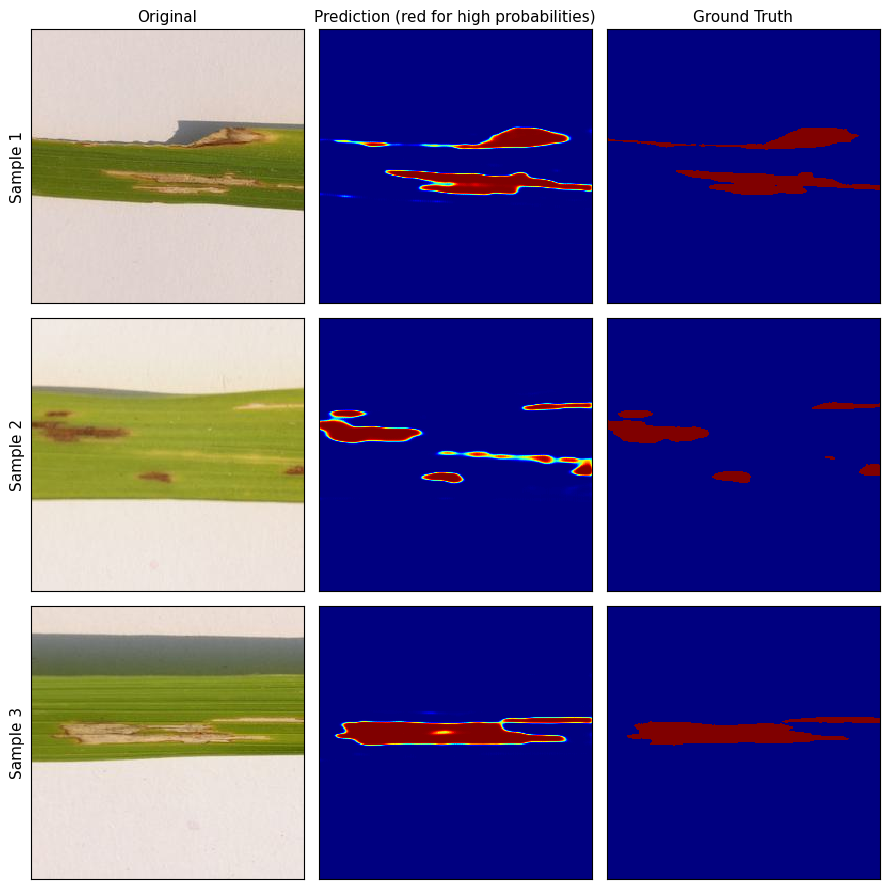

In [ ]:
def plot_samples(X, Y, predictions, sample_indices):
    """
    Plots the original image, prediction, and ground truth for given samples, with titles for each row.

    Parameters:
    - X: the test set images.
    - Y: the ground truth labels for the test set.
    - predictions: the model's predictions.
    - sample_indices: list of indices of the samples to plot.
    - SAVE_RESULTS: Boolean indicating if the results should be saved (default False).
    - PATH_TO_SAVE_RESULT: Path where the plot should be saved if SAVE_RESULTS is True.
    - model_name: Name of the model to use in the filename when saving results.
    """
    num_samples = len(sample_indices)
    fig, axes = plt.subplots(num_samples, 3, figsize=(9, num_samples * 3))  # Adjusted figsize for 3 columns
    plt.subplots_adjust(0, 0, 1, 1, hspace=0.1, wspace=0.1)

    # Titles for the first row
    titles = ['Original', 'Prediction (red for high probabilities)', 'Ground Truth']
    side_titles = ['Sample 1', 'Sample 2', 'Sample 3']  # Side titles for each sample

    for i, sample_index in enumerate(sample_indices):
        data = [
            X[sample_index, ...],
            predictions[sample_index, ..., 0],
            Y[sample_index, ...]
        ]

        cmaps = [None, plt.cm.jet, plt.cm.jet]

        for j, (datum, cmap) in enumerate(zip(data, cmaps)):
            ax = axes[i, j] if num_samples > 1 else axes[j]
            mesh = ax.pcolormesh(datum, cmap=cmap)
            if i == 0:
                ax.set_title(titles[j], fontsize=11)
            if j == 0:
                ax.set_ylabel(side_titles[i], fontsize=11)
            # ax.axis('off')

    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])

    fig.tight_layout()

    if SAVE_RESULTS:
        pdf_filename = os.path.join(PATH_TO_SAVE_RESULT, f"{model_name}_prediction_sample02_color.pdf")
        with PdfPages(pdf_filename) as pdf:
            pdf.savefig()  # saves the current figure into a pdf page
            # plt.close()
            if SHOW_RESULTS:
                plt.show()
            else:
                plt.close()

sample_indices = [0, 13, 4]  # Indices of the samples you want to plot
plot_samples(x_test, y_test, predictions, sample_indices)

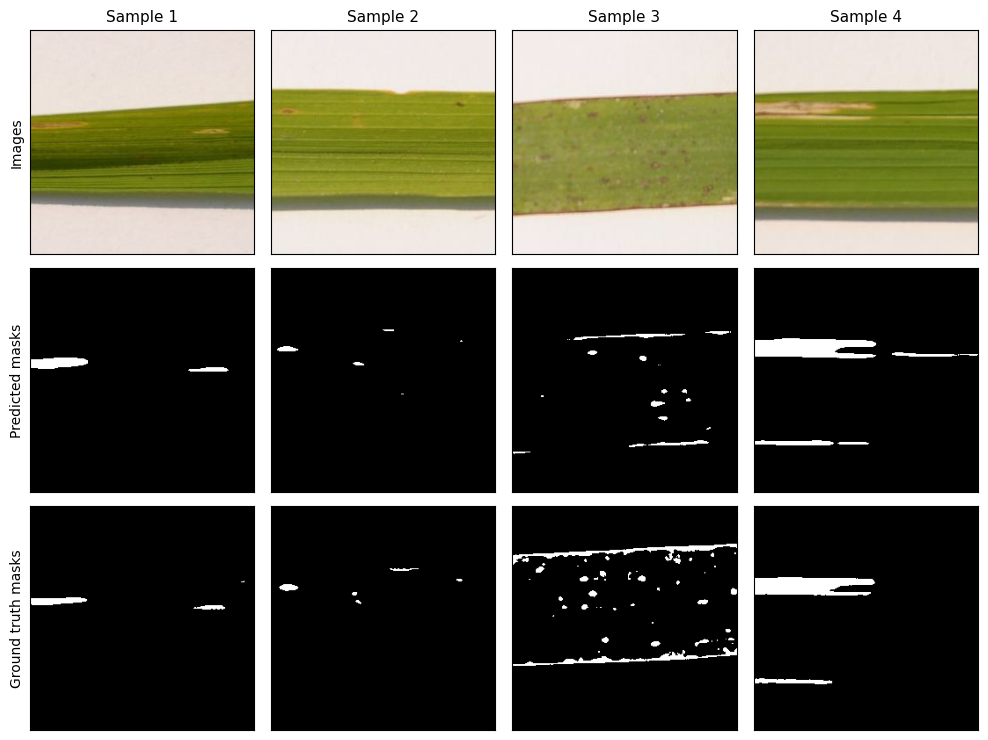

In [ ]:
indices = np.array([i for i in range(len(x_test))])
rand_X_indices = RNG.choice(indices, size=4, replace=False)
rand_X = np.array([x_test[idx] for idx in rand_X_indices])
rand_y = np.array([y_test[idx] for idx in rand_X_indices])
rand_y_predictions = np.array([thresholded_predictions[idx] for idx in rand_X_indices])

fig, ax = plt.subplots(3,4, figsize=(10,7.5))
for i in range(4):
    ax[0,i].imshow(rand_X[i])
    ax[1,i].imshow(rand_y_predictions[i], cmap='gray')
    ax[2,i].imshow(rand_y[i], cmap='gray')

ax[0,0].set_title('Sample 1', fontsize=11)
ax[0,1].set_title('Sample 2', fontsize=11)
ax[0,2].set_title('Sample 3', fontsize=11)
ax[0,3].set_title('Sample 4', fontsize=11)

ax[0,0].set_ylabel('Images')
ax[1,0].set_ylabel('Predicted masks')
ax[2,0].set_ylabel('Ground truth masks')

for axes in ax.flatten():
    axes.set_xticks([])
    axes.set_yticks([])

fig.tight_layout()
# plt.show()

# Save the plot to a PDF
if SAVE_RESULTS:
    pdf_filename = os.path.join(PATH_TO_SAVE_RESULT, f"{model_name}_prediction_sample03.pdf")
    with PdfPages(pdf_filename) as pdf:
        pdf.savefig()  # saves the current figure into a pdf page
        # plt.close()
        if SHOW_RESULTS:
            plt.show()
        else:
            plt.close()

## Test evaluations

In [ ]:
def calculate_test_performance_metrics_all(y_true, y_pred, test_loss ):

    y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)
    y_pred_tensor = tf.convert_to_tensor(y_pred, dtype=tf.float32)

    accuracy_value = accuracy_score(y_true, y_pred)
    precision_value = precision_score(y_true, y_pred)
    recall_value = recall_score(y_true, y_pred)
    f1_score_value = f1_score(y_test_tensor, y_pred_tensor).numpy()

    iou_score_binary.update_state(y_test, y_pred)
    iou_binary = iou_score_binary.result().numpy()

    # Create a dictionary to hold the metrics
    test_results = {
        'Model Name': model_name,
        'Loss': test_loss,
        'Accuracy': accuracy_value,
        'Precision': precision_value,
        'Recall': recall_value,
        'F1-Score': f1_score_value,
        'IoU': iou_binary
    }

        # Convert the dictionary to a DataFrame
    report_df = pd.DataFrame([test_results])

    if SHOW_RESULTS:
        display(report_df)

    if SAVE_RESULTS:
        path_to_save = os.path.join(PATH_TO_SAVE_RESULT, f"{model_name}_model_all_test_performance.csv")
        # Save the DataFrame to a CSV file
        report_df.to_csv(path_to_save , index=False)

In [ ]:
test_loss, test_accuracy, test_f1_score,  test_iou=best_model.evaluate(x_test, y_test)

1/1 [==============================] - 2s 2s/step - loss: 0.0375 - accuracy: 0.9881 - f1_score: 0.8361 - binary_io_u: 0.8531


In [ ]:
calculate_test_performance_metrics_all(y_true=y_test,
                                       y_pred=thresholded_predictions_without_color_channel,
                                       test_loss=test_loss)

,Model Name,Loss,Accuracy,Precision,Recall,F1-Score,IoU
0,Inception_resnetV2_Unet_616,0.037513,0.988147,0.863045,0.810844,0.836131,0.822398


In [ ]:
def calculate_confusion_matrix(y_true, y_pred):
    """
    Calculate the confusion matrix components for a segmentation task.

    Args:
        y_true (numpy.ndarray): The ground truth binary mask.
        y_pred (numpy.ndarray): The predicted binary mask.

    Returns:
        tuple: A tuple containing the counts of TP, FP, FN, TN.
    """
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    TN = np.sum((y_true == 0) & (y_pred == 0))

    return TP, FP, FN, TN


def plot_confusion_matrix(y_true, y_pred, model_name="default_name"): ## WORKS
    """
    Manually plot a confusion matrix for the results of a segmentation task, ensuring all elements are visible,
    with dividing lines between the rows and columns.

    Args:
        y_true (numpy.ndarray): The ground truth binary mask.
        y_pred (numpy.ndarray): The predicted binary mask.
        model_name (str): Optional. The name of the model for titling the plot.
        SAVE_RESULTS (bool): Optional. If True, saves the plot as a PNG file.
    """

    # Calculate the confusion matrix components
    TP, FP, FN, TN = calculate_confusion_matrix(y_true, y_pred)

    # Create the confusion matrix array
    confusion_matrix = np.array([[TP, FP], [FN, TN]])

    fig, ax = plt.subplots(figsize=(3, 3))
    cmap = plt.cm.Greens
    ax.imshow(np.zeros_like(confusion_matrix), cmap=cmap, vmin=0, vmax=1)

    # Annotate the cells with the confusion matrix counts
    for (i, j), val in np.ndenumerate(confusion_matrix):
        ax.text(j, i, f'{val}', ha='center', va='center', color='black', fontsize=11)

    # Set tick labels
    ax.set_xticks([0, 1])
    ax.set_yticks([-0.2, 0.6])
    ax.set_xticklabels(['Disease', 'Background'], fontsize=11)
    ax.set_yticklabels(['Disease', 'Background'], fontsize=11)

    # Remove the ticks while keeping the labels
    ax.tick_params(axis='x', which='both', length=0) # Removes x-axis ticks
    ax.tick_params(axis='y', which='both', length=0) # Removes y-axis ticks

    # Rotate y-axis labels
    plt.yticks(rotation=90)

    # Set axis labels and title
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

    # adding borders to the plot
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    # Draw dividing lines between the rows and columns
    ax.axhline(y=0.5, color='black', linewidth=1)
    ax.axvline(x=0.5, color='black', linewidth=1)

    plt.tight_layout()

    # Save the plot to a PDF
    if SAVE_RESULTS:
        pdf_filename = os.path.join(PATH_TO_SAVE_RESULT, f"{model_name}_confusion_matrix.pdf")
        with PdfPages(pdf_filename) as pdf:
            pdf.savefig()  # saves the current figure into a pdf page
            # plt.close()
            if SHOW_RESULTS:
                plt.show()
            else:
                plt.close()

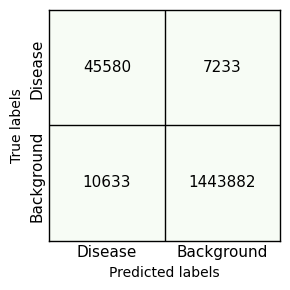

In [ ]:
plot_confusion_matrix(y_true=y_test,
                      y_pred=thresholded_predictions_without_color_channel,
                      model_name=model_name)